In [18]:
import sys
sys.path.append('/home/jp/Documents/GitProjects/faas-sim')
from typing import List

import matplotlib.pyplot as plt
from pandas import DataFrame
import pandas as pd
import numpy as np
import pickle
import datetime as dt
import matplotlib.dates as md
from matplotlib import ticker
import re

from ext.jjnp21.automator.experiment import Result
from ext.jjnp21.automator.analyzer import BasicResultAnalyzer



def load_results(path) -> List[Result]:
    with open(path, 'rb') as f:
        results = pickle.load(f)
        return results

In [132]:
results = load_results('/home/jp/Documents/tmp/optimization_aggressiveness4.dump')

In [134]:
def cut_to_latter_half(result):
    count = len(result.invocations)
    result.invocations = result.invocations[int((count/5)*4):]
    return result

In [135]:
cut_results = list(map(lambda r: cut_to_latter_half(r), results))

In [137]:
analyzer = BasicResultAnalyzer(cut_results)
analysis = analyzer.basic_kpis()

In [136]:
len(results[0].invocations)

90534

In [22]:
def kpis_by_expname(expname):
    return analysis[analysis['name'] == expname]

In [138]:
def build_results_table(results):
    rows = []
    for r in sorted(results, key=lambda r: r.experiment.name, reverse=True):
        row = {}
        row['Pressure Threshold'] = r.experiment.name[34:38]
        row['LB Replicas'] = r.lb_replica_count['running_lb_replicas'].iloc[-1].astype(int)
        row['Mean TRT'] = f'{round(kpis_by_expname(r.experiment.name)["E2E mean"].iloc[0].astype(float) * 1000, 1)}ms'
        row['Mean FET'] = f'{round(kpis_by_expname(r.experiment.name)["FET mean"].iloc[0].astype(float) * 1000, 1)}ms'
        row['Mean LB_FX'] = f'{round(kpis_by_expname(r.experiment.name)["tx_time_lb_fx mean"].iloc[0].astype(float) * 1000, 1)}ms'
        row['Mean CL_LB'] = f'{round(kpis_by_expname(r.experiment.name)["tx_time_cl_lb mean"].iloc[0].astype(float) * 1000, 1)}ms'
        rows.append(row)
    return pd.DataFrame(rows)

res_table = build_results_table(results)
res_table.to_csv('/home/jp/Documents/Thesis/experiments/8_osmotic_optimization_aggressiveness/raw_data/last_20_percent.csv')
res_table

,Pressure Threshold,LB Replicas,Mean TRT,Mean FET,Mean LB_FX,Mean CL_LB
0,0.1,4,157.1ms,30.0ms,34.3ms,92.2ms
1,0.09,4,154.4ms,28.7ms,32.5ms,92.7ms
2,0.08,6,151.4ms,30.5ms,28.4ms,92.2ms
3,0.07,5,150.4ms,29.9ms,28.0ms,91.6ms
4,0.06,5,154.2ms,31.3ms,30.5ms,92.0ms
5,0.05,5,152.8ms,30.2ms,30.2ms,91.6ms
6,0.04,5,151.8ms,30.4ms,28.8ms,91.8ms
7,0.03,7,149.7ms,29.6ms,27.9ms,91.6ms
8,0.02,20,141.6ms,27.8ms,22.6ms,91.4ms


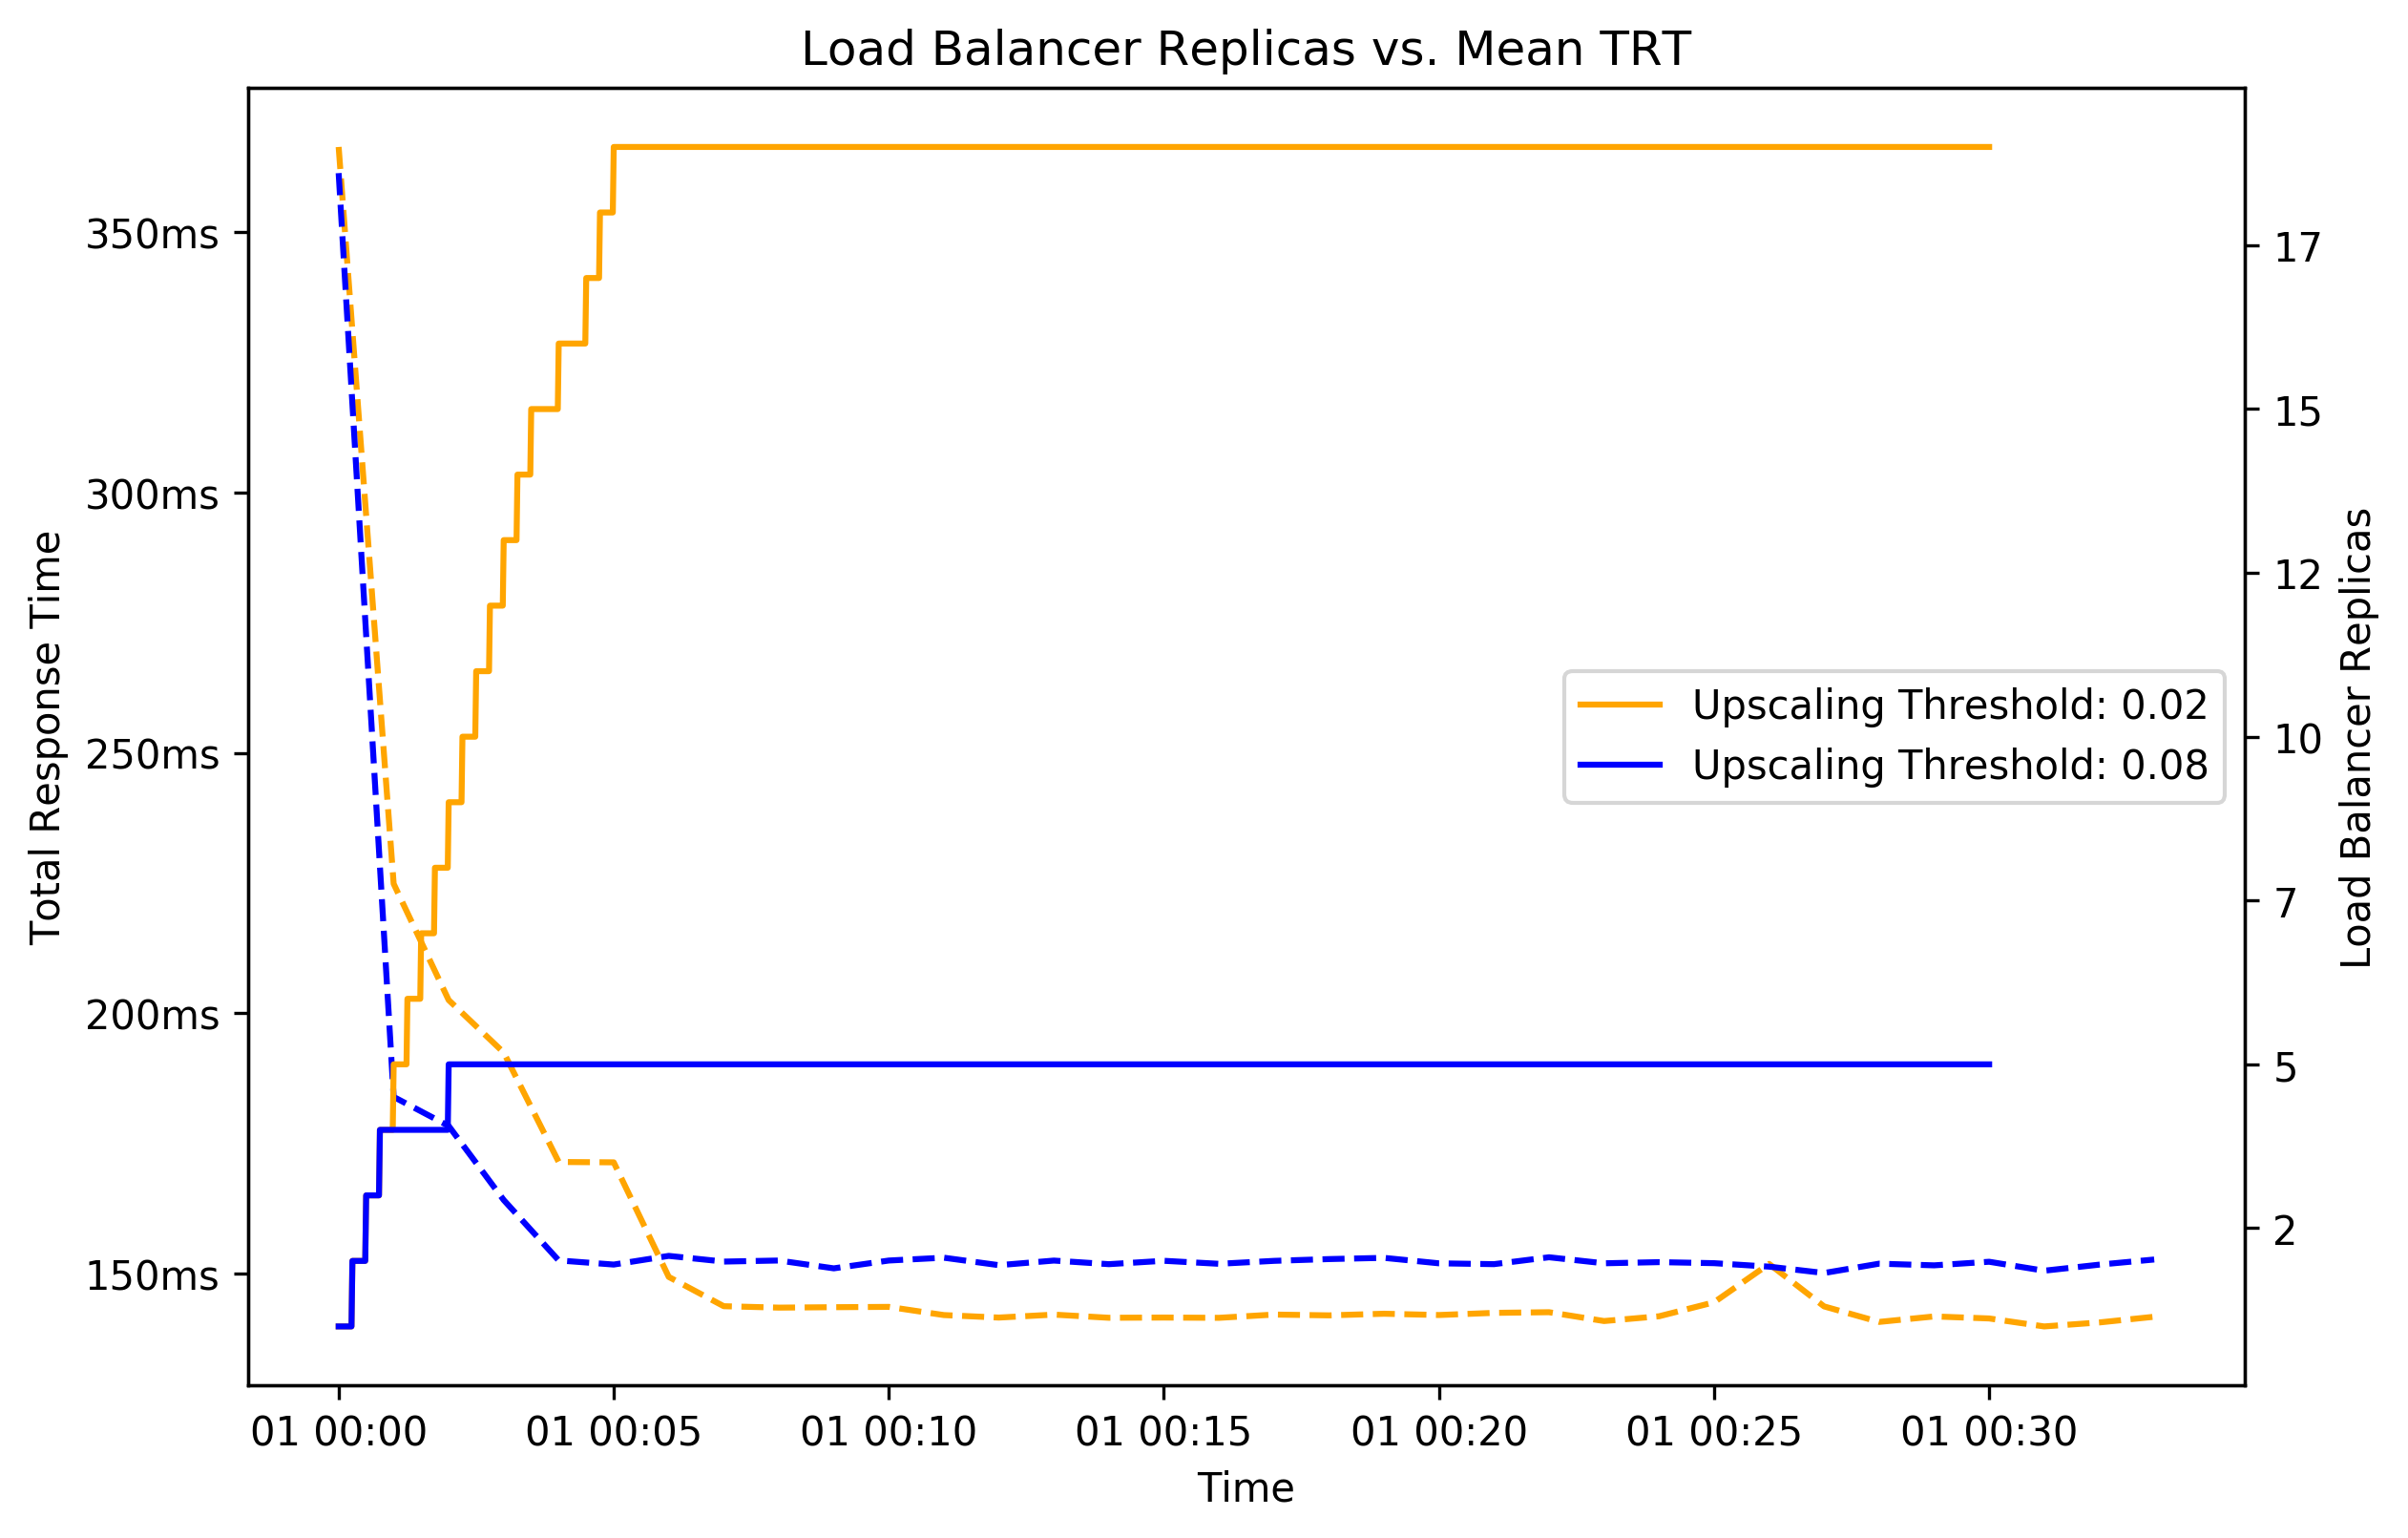

In [114]:
def paint(rs, ax):
    timebase = dt.datetime(1970,1,1)
    
    xfmt = md.DateFormatter('%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    t_index = pd.DatetimeIndex(pd.date_range(start=dt.datetime(1970,1,1,0,0,0), end=dt.datetime(1970,1,1,0,30,0), freq="1s"))
    
    
    @ticker.FuncFormatter
    def ms_formatter(x, pos):
        return f'{str(int(x * 1000))}ms'
    
    @ticker.FuncFormatter
    def replica_formatter(x, pos):
        return f'{str(int(x))}'
    
    ax.yaxis.set_major_formatter(ms_formatter)
    ax2 = ax.twinx()
    ax2.yaxis.set_major_formatter(replica_formatter)
    colors = ['orange', 'blue']
    for index, r in enumerate(rs):
        inv = r.invocations
        sc = r.lb_replica_count
        delta = inv.iloc[0].name - timebase
        delta_sc = sc.iloc[0].name - timebase
        name = f'Upscaling Threshold: {r.experiment.name[34:38]}'
        ax.plot(inv.shift(freq=-delta)['t_exec'].resample('60s').mean(), label=name, color=colors[index], linestyle='dashed')
        ax2.plot(sc.shift(freq=-delta_sc)['running_lb_replicas'].resample('1s').pad().reindex(t_index).fillna(method='pad'), label=name, color=colors[index])
    ax2.legend(loc='right')
    ax.set_xlabel('Time')
    ax.set_ylabel('Total Response Time')
    ax2.set_ylabel('Load Balancer Replicas')
    
fix, ax = plt.subplots(1, 1, figsize=(9,6), dpi=300)
ax.set_title('Load Balancer Replicas vs. Mean TRT')
paint([results[8], results[7]], ax)
fig.tight_layout()
plt.show()

In [53]:
results[8].lb_replica_count

,running_lb_replicas
time,
2022-03-11 17:55:54.047674,1
2022-03-11 17:56:09.043244,2
2022-03-11 17:56:24.043215,3
2022-03-11 17:56:39.043487,4
2022-03-11 17:56:54.043498,5
2022-03-11 17:57:09.043848,6
2022-03-11 17:57:24.043867,7
2022-03-11 17:57:39.043872,8
2022-03-11 17:57:54.043911,9
